In [2]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../src/')
from train import load_data
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, Discriminator
import magic
import torch
import pathlib
import copy

import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeOverfit
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from tqdm import tqdm

wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [34]:
def _distance_to_geodesic_criterion(predicted_geodesic, true_geodesic):
    # the inputs here are single samples from a geodesic; should be shape num_samples x num_dims
    # for each input point, we want the closest distance to any point on the true geodesic using the euclidean distance, torch.cdist
    D = torch.cdist(predicted_geodesic, true_geodesic)
    min_dists_to_true_geodesic = D.min(dim=1)[0]
    # we take the mean of the squared distances
    return torch.mean(min_dists_to_true_geodesic**2)
# def distance_to_geodesic_criterion(
#     predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
#     true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
#     ):
#     """
#     Mean of the squared distances from each predicted point to the closest point on the true geodesic
#     """
#     dists = []
#     for i in range(predicted_geodesic.shape[0]):
#         dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
#     dists = torch.stack(dists)
#     return dists.mean()

def distance_to_geodesic_criterion_len(
    predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
    true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
    lengths=1.,
    ):
    """
    Mean of the squared distances from each predicted point to the closest point on the true geodesic
    """
    dists = []
    for i in range(predicted_geodesic.shape[0]):
        dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
    dists = torch.stack(dists)
    dists = dists / lengths
    return dists.mean()

def distances_to_geodesic(
    predicted_geodesic:torch.Tensor, # size num_geodesics x num_samples x num_dims
    true_geodesic:torch.Tensor, # size num_geodesics num_samples x num_dims. But it's okay if the num_samples are different
    ):
    """
    Mean of the squared distances from each predicted point to the closest point on the true geodesic
    """
    dists = []
    for i in range(predicted_geodesic.shape[0]):
        dists.append(_distance_to_geodesic_criterion(predicted_geodesic[i], true_geodesic[i]))
    dists = torch.stack(dists)
    return dists

In [35]:
entity = "xingzhis"
project = "dmae"
sweep_id = 'letz1d24'
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

In [36]:
names = df[(df['loss_epoch']!='NaN')][['data_name']].values.flatten()

  0%|          | 0/29 [00:00<?, ?it/s]/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.
  rank_zero_warn(


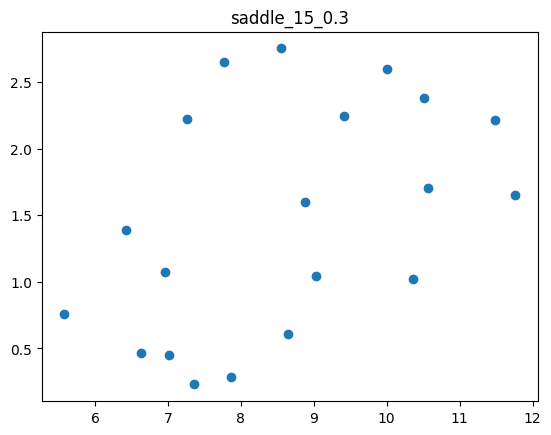

  3%|▎         | 1/29 [00:00<00:16,  1.70it/s]

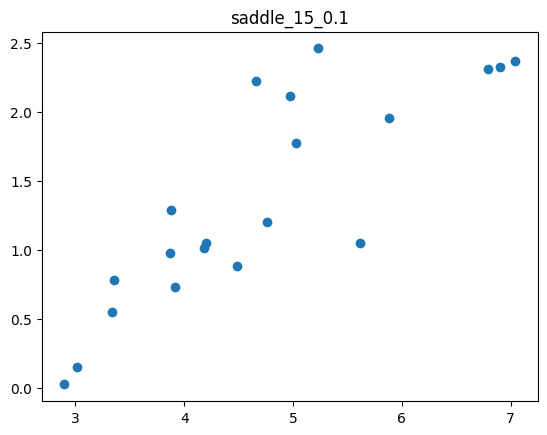

  7%|▋         | 2/29 [00:01<00:15,  1.69it/s]

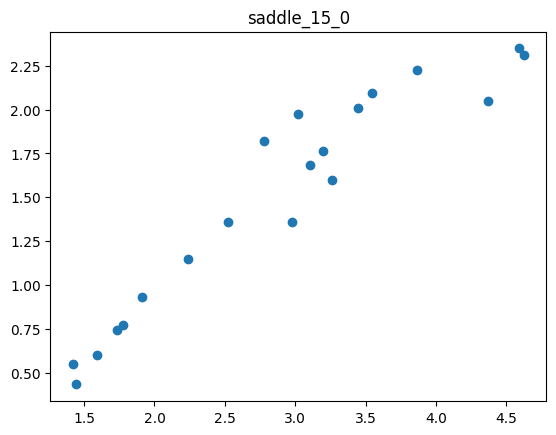

 10%|█         | 3/29 [00:01<00:15,  1.66it/s]

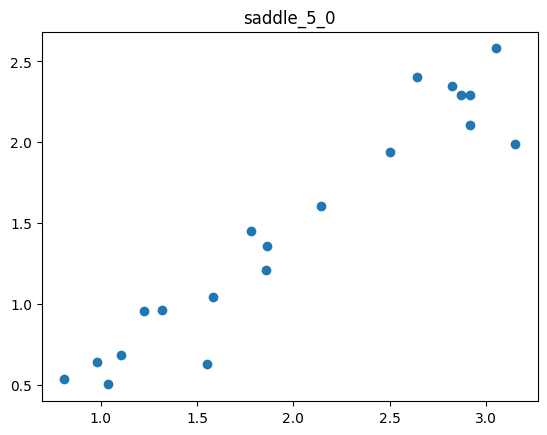

 14%|█▍        | 4/29 [00:02<00:12,  2.03it/s]

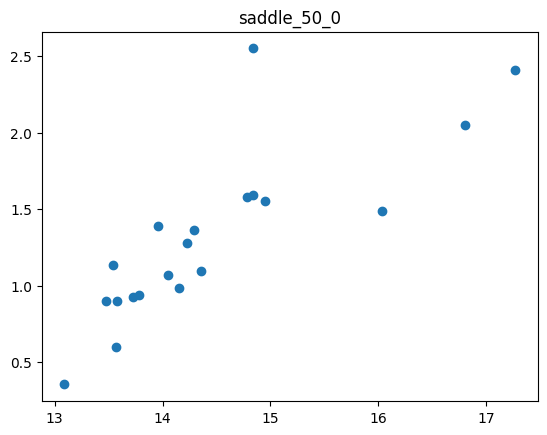

 17%|█▋        | 5/29 [00:04<00:28,  1.19s/it]

list index out of range


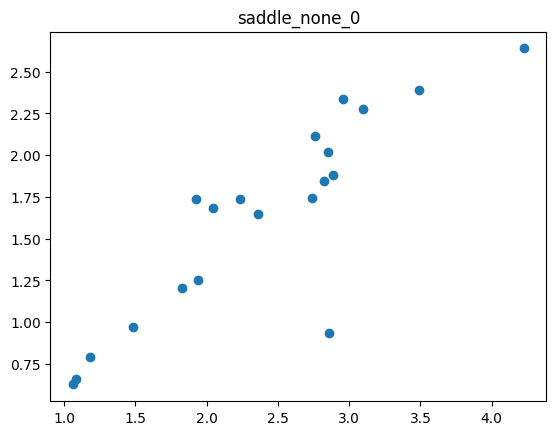

 24%|██▍       | 7/29 [00:04<00:14,  1.50it/s]

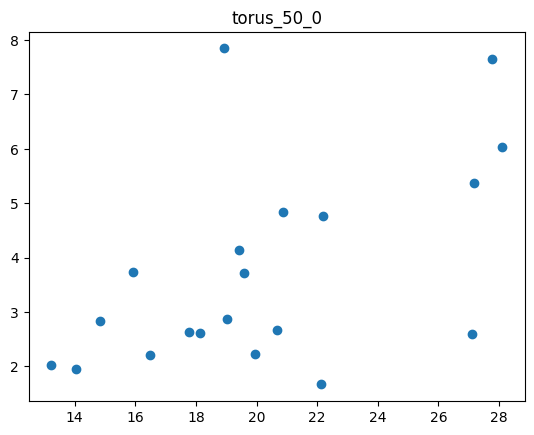

 28%|██▊       | 8/29 [00:07<00:23,  1.11s/it]

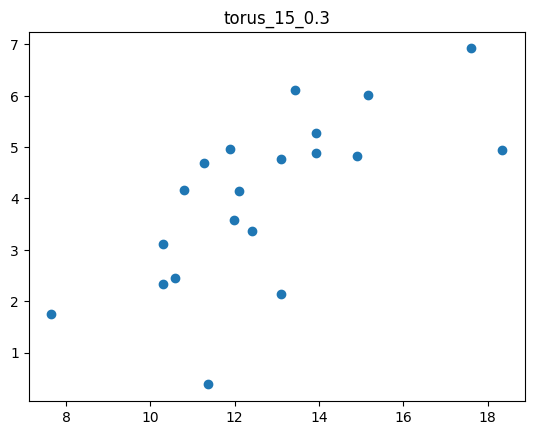

 34%|███▍      | 10/29 [00:07<00:14,  1.30it/s]

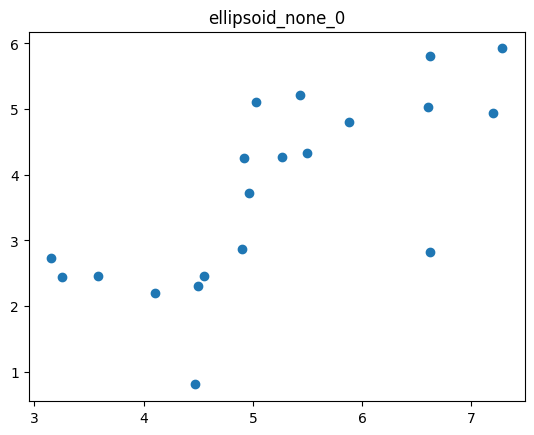

 41%|████▏     | 12/29 [00:08<00:09,  1.89it/s]

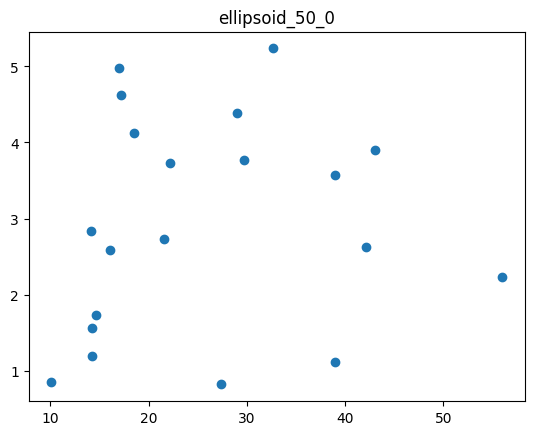

 45%|████▍     | 13/29 [00:09<00:12,  1.24it/s]

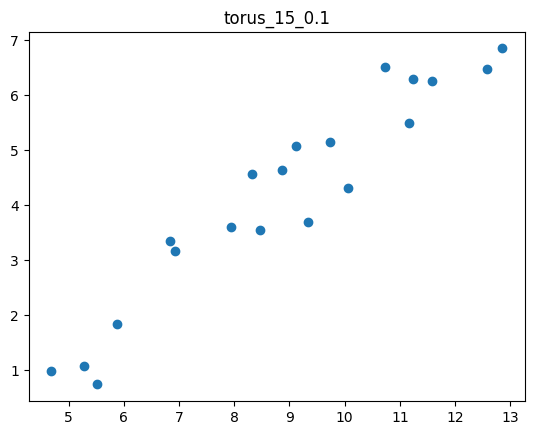

 48%|████▊     | 14/29 [00:10<00:11,  1.32it/s]

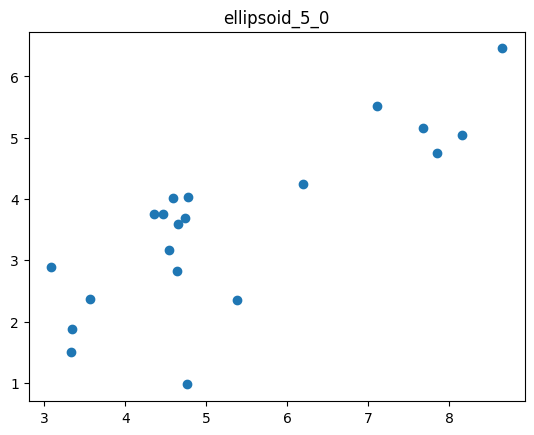

 52%|█████▏    | 15/29 [00:10<00:09,  1.53it/s]

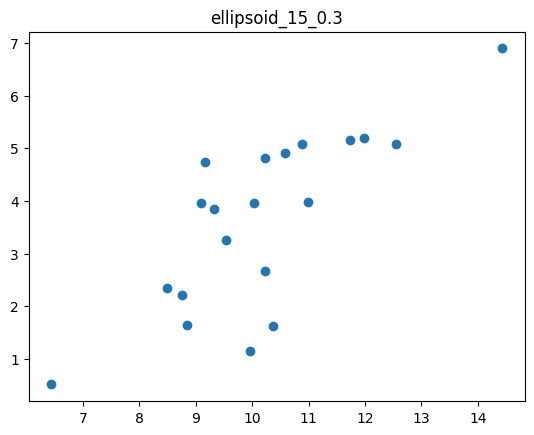

 55%|█████▌    | 16/29 [00:11<00:09,  1.32it/s]

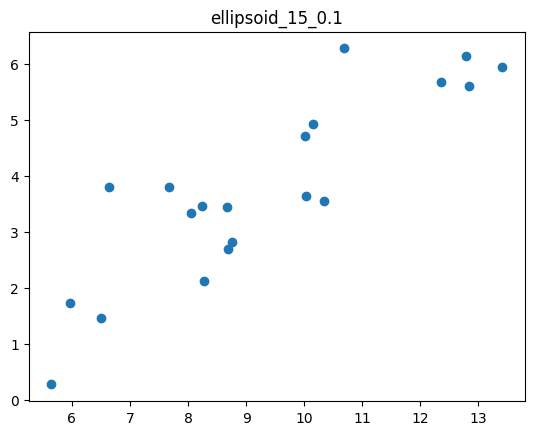

 62%|██████▏   | 18/29 [00:12<00:06,  1.77it/s]

CANNOT FIND FILE swissroll_15_0.3.npz


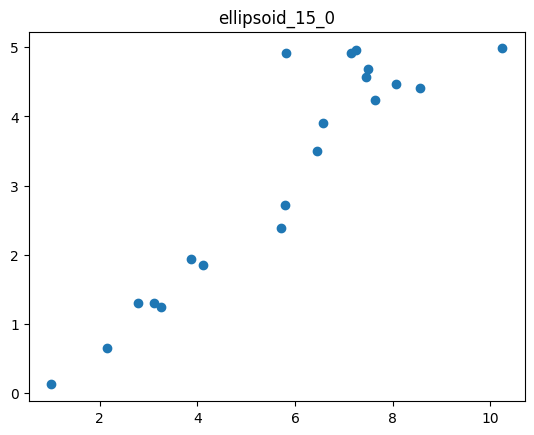

 79%|███████▉  | 23/29 [00:13<00:01,  4.22it/s]

CANNOT FIND FILE swissroll_15_0.npz
CANNOT FIND FILE swissroll_15_0.1.npz
CANNOT FIND FILE swissroll_none_0.npz
CANNOT FIND FILE swissroll_50_0.npz
CANNOT FIND FILE swissroll_5_0.npz


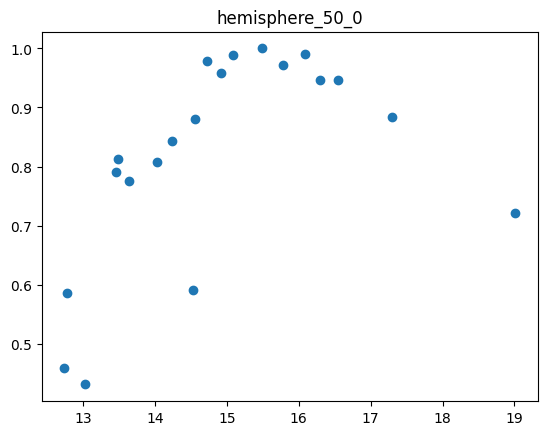

 86%|████████▌ | 25/29 [00:15<00:02,  1.89it/s]

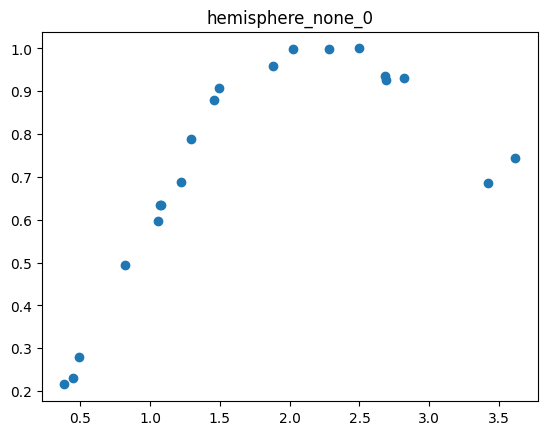

 90%|████████▉ | 26/29 [00:16<00:01,  2.08it/s]

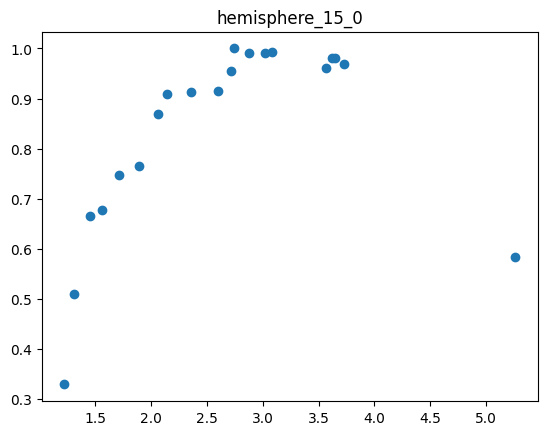

 93%|█████████▎| 27/29 [00:16<00:01,  1.96it/s]

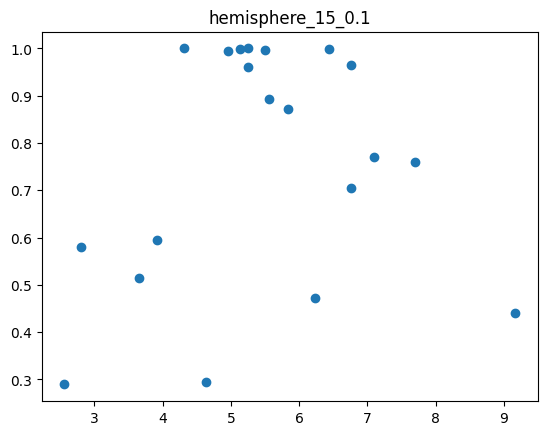

 97%|█████████▋| 28/29 [00:17<00:00,  1.88it/s]

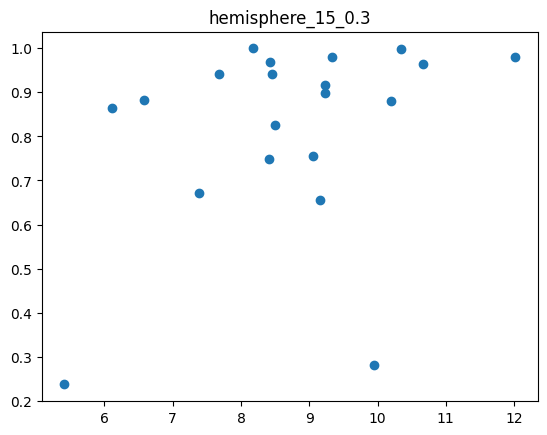

100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


In [56]:

res_list = []

for data_name in tqdm(names):
    try:
        entity = "xingzhis"
        project = "dmae"
        sweep_id = '59muwbsf'
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

        runs_data = []

        # Iterate through each run in the sweep
        for run in sweep.runs:
            # Extract metrics and configs
            metrics = run.summary._json_dict
            configs = run.config
            
            # Combine metrics and configs, and add run ID
            combined_data = {**metrics, **configs, "run_id": run.id}
            
            # Append the combined data to the list
            runs_data.append(combined_data)

        # Create a DataFrame from the runs data
        df = pd.DataFrame(runs_data)

        # run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
        run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == 1.0) & (df['dimensions.latent'] == 3)]['run_id']
        assert len(run_ids) == 1
        run_id = run_ids.iloc[0]
        run = api.run(f"{entity}/{project}/{run_id}")
        # run = api.run(f"{entity}/{project}/{run_id}")
        folder_path = '../../src/wandb/'
        cfg = OmegaConf.create(run.config)
        folder_list = glob.glob(f"{folder_path}*{run.id}*")
        ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
        ckpt_path = ckpt_files[0]
        cfg.data.root = '../' + cfg.data.root
        model = Autoencoder.load_from_checkpoint(ckpt_path)
        data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)



        # sweep_id = 'ywep3ixr'
        # sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        # # Initialize an empty list to store run data
        # runs_data = []

        # # Iterate through each run in the sweep
        # for run in sweep.runs:
        #     # Extract metrics and configs
        #     metrics = run.summary._json_dict
        #     configs = run.config
            
        #     # Combine metrics and configs, and add run ID
        #     combined_data = {**metrics, **configs, "run_id": run.id}
            
        #     # Append the combined data to the list
        #     runs_data.append(combined_data)

        # # Create a DataFrame from the runs data
        # df = pd.DataFrame(runs_data)
        # run_ids = df[(df['data.name'] == data_name)][['run_id']]
        # assert len(run_ids) == 1
        # run_id = run_ids.iloc[0]
        # run = api.run(f"{entity}/{project}/{run_ids.iloc[0].values[0]}")
        # folder_path = '../../src/wandb/'
        # cfg = OmegaConf.create(run.config)
        # folder_list = glob.glob(f"{folder_path}*{run.id}*")
        # ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
        # ckpt_path = ckpt_files[0]
        # cfg.data.root = '../' + cfg.data.root
        # discriminator = Discriminator.load_from_checkpoint(ckpt_path)



        entity = "xingzhis"
        project = "dmae"
        sweep_id = 'letz1d24'
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        runs_data = []

        # Iterate through each run in the sweep
        for run in sweep.runs:
            # Extract metrics and configs
            metrics = run.summary._json_dict
            configs = run.config
            
            # Combine metrics and configs, and add run ID
            combined_data = {**metrics, **configs, "run_id": run.id}
            
            # Append the combined data to the list
            runs_data.append(combined_data)

        # Create a DataFrame from the runs data
        df = pd.DataFrame(runs_data)

        run_ids = df[(df['data_name'] == data_name) & (df['loss_epoch'] != 'NaN')]['run_id']
        assert len(run_ids) == 1
        run_id = run_ids.iloc[0]
        run = api.run(f"{entity}/{project}/{run_id}")
        cfg_main = OmegaConf.create(run.config)
        folder_path = './wandb/'
        folder_list = glob.glob(f"{folder_path}*{run.id}*")
        ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
        ckpt_path = ckpt_files[0]

        x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
        xbatch = torch.tensor(data['start_points'], dtype=x.dtype, device=x.device)
        xendbatch = torch.tensor(data['end_points'], dtype=x.dtype, device=x.device)
        # xbatch = model.encoder.preprocessor.normalize(xbatch)
        # xendbatch = model.encoder.preprocessor.normalize(xendbatch)
        # if cfg_main.overfit:
        #     ids = torch.eye(xbatch.size(0))
        # else:
        ids = torch.zeros((xbatch.size(0),1))
        dataset = TensorDataset(xbatch, xendbatch, ids)
        dataloader = DataLoader(dataset, batch_size=len(x), shuffle=False)

        for param in model.encoder.parameters():
            param.requires_grad = False
        # def func(x):
        #     return model.encoder(x)
        # for param in discriminator.parameters():
        #     param.requires_grad = False
        # def discriminator_func_for_grad(x):
        #     return discriminator.positive_proba(x, normalize=False).reshape(-1,1)
        # def discriminator_func(x):
        #     return discriminator.positive_proba(x, normalize=False).reshape(-1,1)
        ofm = lambda x: x
        gbmodel = GeodesicBridgeOverfit.load_from_checkpoint(
            checkpoint_path=ckpt_path,
            func=ofm,
            # func = enc_func,
            # discriminator_func=disc_func_pen,
            # discriminator_func_for_grad=discriminator_func_for_grad,
            input_dim=x.size(1), 
            hidden_dim=64, 
            scale_factor=1, 
            symmetric=True, 
            num_layers=3, 
            n_tsteps=100, 
            lr=1e-3, 
            weight_decay=1e-3,
            discriminator_weight=0.,
            discriminator_func_for_grad_weight=0.,
            id_dim=1,
            id_emb_dim=1,
            density_weight=0.,
            length_weight=1.,
        )

        # batch = next(iter(dataloader))
        # x0, x1, ids = batch
        try:
            if data_name.startswith('hemisphere'):
                data_gt = np.load(f"../../data/gt_geodesic/{data_name}.npz", allow_pickle=True)
            else:
                data_gt = np.load(f"../../data/gt_geodesic_w_geod_2//{data_name}.npz", allow_pickle=True)
        except:
            print(f"CANNOT FIND FILE {data_name}.npz")
            continue
        xbatch = torch.tensor(data_gt['start_points'], dtype=x.dtype, device=x.device)
        xendbatch = torch.tensor(data_gt['end_points'], dtype=x.dtype, device=x.device)
        x0 = xbatch
        x1 = xendbatch
        # xbatch = model.encoder.preprocessor.normalize(xbatch)
        # xendbatch = model.encoder.preprocessor.normalize(xendbatch)
        ids = torch.zeros((xbatch.size(0),1))
        # ids = torch.eye((xbatch.size(0)))

        # dataset = TensorDataset(xbatch, xendbatch, ids)
        # dataloader = DataLoader(dataset, batch_size=len(z), shuffle=True)

        def cc_func(x0, x1, t):
            return gbmodel.cc(x0, x1, t, ids)
        vectors = velocity(cc_func, gbmodel.ts, x0, x1)
        cc_pts = gbmodel.cc(x0, x1, gbmodel.ts, ids)
        vectors_flat = vectors.flatten(0,1)
        cc_pts_flat = cc_pts.flatten(0, 1)
        jac_flat = jacobian(gbmodel.func, cc_pts_flat)
        length_all = torch.sqrt((torch.einsum("nij,nj->ni", jac_flat, vectors_flat)**2).sum(axis=1))
        length_all = length_all.reshape(vectors.shape[0], vectors.shape[1])
        length = length_all.mean(axis=0)

        geods = (cc_pts_flat).reshape(cc_pts.shape)
        length2 = torch.sqrt(torch.diff(geods, axis=0)**2).sum(axis=-1).sum(axis=0)


        plt.scatter(length2.detach().numpy(), data_gt['geodesic_lengths'])
        plt.title(data_name)
        plt.show()

        # gt_len = torch.tensor(data_gt['geodesic_lengths'])
        true_geod = torch.tensor(data_gt['geodesics'], dtype=torch.float32)
        gt_len = torch.sqrt(torch.diff(true_geod.permute(1,0,2), axis=0)**2).sum(axis=-1).sum(axis=0)
        corr = np.corrcoef(length.detach().numpy(), gt_len.cpu().numpy())[0,1]
        mse = ((length.detach().numpy() - gt_len.cpu().numpy())**2).mean()
        dist2geod = distance_to_geodesic_criterion_len(geods.permute(1,0,2), true_geod, lengths=gt_len).detach().numpy()

        res_list.append(dict(
            name=data_name,
            length_corr=corr,
            length_mse=mse,
            dist2geod=dist2geod
        ))
    except Exception as e:
        print(e)

In [57]:
res_df = pd.DataFrame(res_list)

In [58]:
res_df

,name,length_corr,length_mse,dist2geod
0,saddle_15_0.3,0.525326,2.657408,0.6966475
1,saddle_15_0.1,0.919844,2.807751,0.17440525
2,saddle_15_0,0.980407,4.017247,0.011003403
3,saddle_5_0,0.974674,1.853729,0.012711028
4,saddle_50_0,0.929290,1.578305,0.50782037
5,saddle_none_0,0.827987,1.288760,0.028339291
6,torus_50_0,0.815402,20.077843,0.23145513
7,torus_15_0.3,0.791271,19.831907,0.24196425
8,ellipsoid_none_0,0.647797,5.982457,0.13451652
9,ellipsoid_50_0,0.165931,11.137118,0.6690079


In [59]:
res_df.sort_values('length_corr', ascending=False)

,name,length_corr,length_mse,dist2geod
16,hemisphere_none_0,0.994304,0.479584,0.0032364756
17,hemisphere_15_0,0.988123,2.344779,0.0042916625
2,saddle_15_0,0.980407,4.017247,0.011003403
3,saddle_5_0,0.974674,1.853729,0.012711028
10,torus_15_0.1,0.959668,29.986919,0.06858031
15,hemisphere_50_0,0.950530,1.644478,0.6426599
18,hemisphere_15_0.1,0.942402,3.332137,0.12653019
4,saddle_50_0,0.929290,1.578305,0.50782037
1,saddle_15_0.1,0.919844,2.807751,0.17440525
14,ellipsoid_15_0,0.901334,17.006296,0.024983667


In [60]:
res_df

,name,length_corr,length_mse,dist2geod
0,saddle_15_0.3,0.525326,2.657408,0.6966475
1,saddle_15_0.1,0.919844,2.807751,0.17440525
2,saddle_15_0,0.980407,4.017247,0.011003403
3,saddle_5_0,0.974674,1.853729,0.012711028
4,saddle_50_0,0.929290,1.578305,0.50782037
5,saddle_none_0,0.827987,1.288760,0.028339291
6,torus_50_0,0.815402,20.077843,0.23145513
7,torus_15_0.3,0.791271,19.831907,0.24196425
8,ellipsoid_none_0,0.647797,5.982457,0.13451652
9,ellipsoid_50_0,0.165931,11.137118,0.6690079


In [63]:
len([n for n in names if n.startswith('swiss')])

6

In [ ]:
['swissroll_15_0.3','swissroll_15_0','swissroll_15_0.1','swissroll_none_0','swissroll_50_0','swissroll_5_0']